# Exploratory Data Analysis

EDA is one of the areas of data science that can be more 'art' than 'science'. This is the time to get intimate with your data.

## Objectives

1. Know what questions to ask, that will help you get to know your data.
    - What are the data types?
    - What is the distribution of the target?
    - Are there missing values?
    - What are the distributions of my features?
    - How does each feature relate to the target?
    - How do my features relate to each other?
2. Use standard tools from Pandas, Matplotlib, Seaborn to perform EDA.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load Data

In [2]:
cars = pd.read_csv('data/cars_multivariate.csv', na_values=['?'])
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15,8,350,165,3693,11.5,70,1,buick skylark 320
2,18,8,318,150,3436,11.0,70,1,plymouth satellite
3,16,8,304,150,3433,12.0,70,1,amc rebel sst
4,17,8,302,140,3449,10.5,70,1,ford torino


## What are the data types?
- Do they make sense?
- Is there anything I want to change?

In [3]:
cars.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model             int64
origin            int64
car_name         object
dtype: object

'Model' Refers to model year. Let's change this

In [4]:
cars = cars.rename(columns = {'model' : 'model_year'})

'origin' is an integer encoded categorical variable.  
1: US  
2: Japan  
3: Europe

In [5]:
cars['origin'] = cars.origin.astype('category')
cars.origin.cat.categories = ['US', 'Japan', 'Europe']
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18,8,307,130,3504,12.0,70,US,chevrolet chevelle malibu
1,15,8,350,165,3693,11.5,70,US,buick skylark 320
2,18,8,318,150,3436,11.0,70,US,plymouth satellite
3,16,8,304,150,3433,12.0,70,US,amc rebel sst
4,17,8,302,140,3449,10.5,70,US,ford torino


Make a note of all variables types.

In [6]:
cat_vars = ['origin', 'car_name']
num_vars = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
target = 'mpg'

#### Notes:
- We may want to revisit `cylinders`, as this could potentially be categorical.

## What is the distribution of the target?

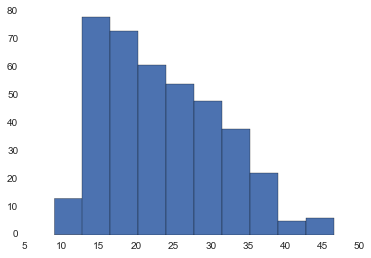

In [7]:
cars[target].hist()

#### Notes:
- Definitely not normally distributed
- Gamma? Lognormal?

## Are there missing values?

In [8]:
num_missing = cars.apply(lambda col: col.isnull().sum())
num_missing

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

#### Notes:
- This is probably a small enough number of missing values that we can just drop the rows.
- Otherwise, we would want to check whether the missing values are correlated with anything else in the data
- There is no easy way to know the best thing to do with missing values.
    - Impute (e.g. replace with the most common value from that column)
    - Remove
    - Encode (e.g. add a category '?' to your categorical variable, or a binary column hp_is_missing)

In [9]:
# Remove rows with missing values
cars = cars.loc[cars.horsepower.notnull(),:]

## What are the distributions of my features?

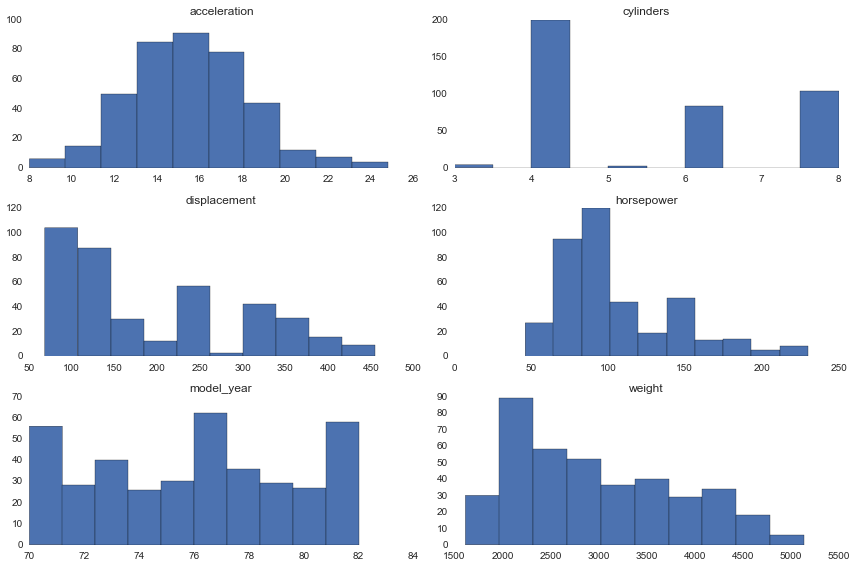

In [10]:
# Histograms of numeric variables
ax = cars[num_vars].hist(bins=10, figsize=(12,8))
plt.tight_layout()

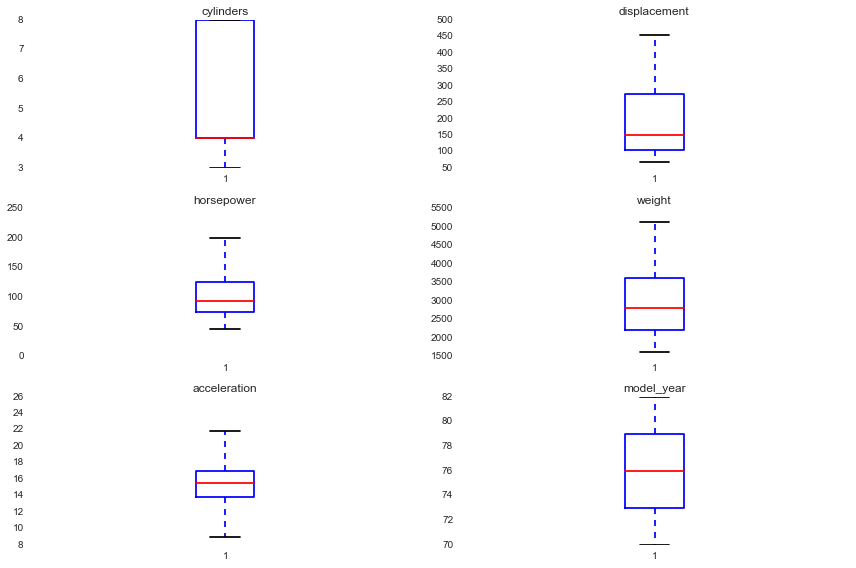

In [11]:
# Boxplots
fig, axes = plt.subplots(3,2, figsize=(12,8))
for ax, var in zip(axes.ravel(), num_vars):
    ax.boxplot(cars[var])
    ax.set_title(var)
plt.tight_layout()

In [12]:
# Categorical variables
for var in cat_vars:
    print cars[var].value_counts().head()
    print 


US        245
Europe     79
Japan      68
dtype: int64

ford pinto          5
toyota corolla      5
amc matador         5
chevrolet impala    4
ford maverick       4
dtype: int64



In [13]:
# How many cars show up 5 times, 4 times, etc...?
cars['car_name'].value_counts().value_counts()

1    245
2     34
3     12
4      7
5      3
dtype: int64

#### Notes
- origin is a 'simple' categorical variable
- car_name is not useful for prediction, just a description of each data point.
- There are a handful of 3,5, and 7 cylinder cars - might want to exclude these.
- No clear outliers in any of the variables (except for cylinders)

## How does each feature relate to the target?

### Numeric

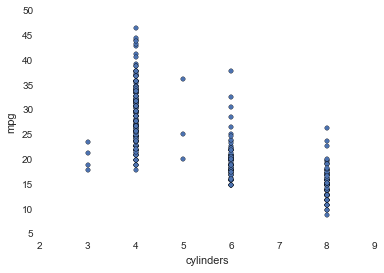

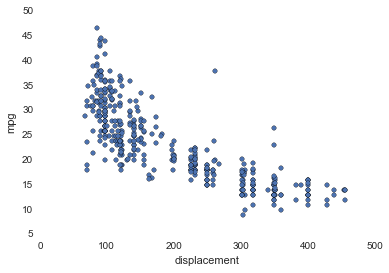

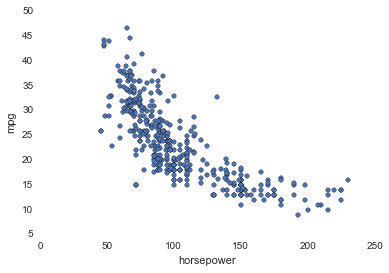

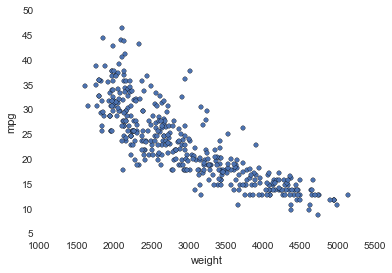

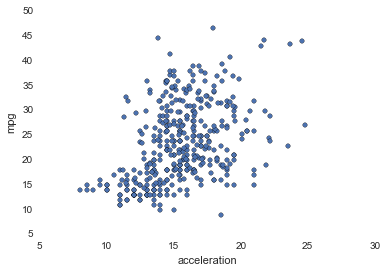

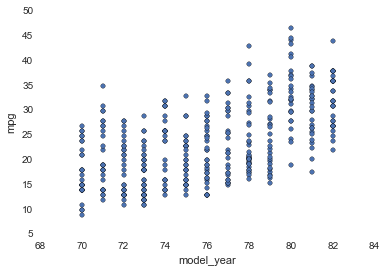

In [14]:
for var in num_vars:
    cars.plot(x=var, y=target, kind='scatter')

#### Notes:
- HP, Displacement, and Weight all seem to have the same relationship with MPG

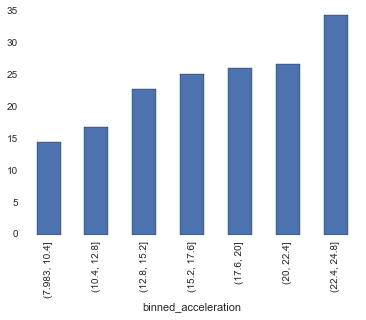

In [15]:
# Use binning to see relationships more clearly
cars['binned_acceleration'] = pd.cut(cars.acceleration, bins=7)
agg = cars.groupby('binned_acceleration')['mpg'].mean()
agg.plot(kind='bar')

#### Notes:
- Accelerationl is related to MPG, but not as strongly as the other variables.

### Categorical

origin
US        20.033469
Japan     27.602941
Europe    30.450633
Name: mpg, dtype: float64


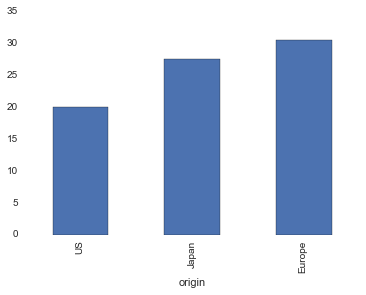

In [16]:
# Categorical
agg = cars.groupby('origin')[target].mean()
print agg
agg.plot(kind='bar')

For a more detailed view, use overlapping histograms

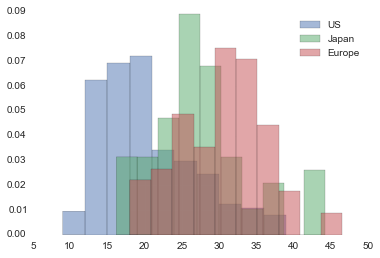

In [17]:
grouped = cars.groupby('origin')
for name, group in grouped:
    group.mpg.hist(alpha=.5, normed=True, label=name)
plt.legend()

### Relationships with more than one feature

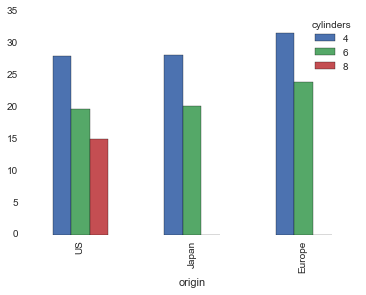

In [18]:
# Origin and Cylinders vs mpg
# Restrict to 4,6,8 cylinders for ease of interpretation
cars = cars.loc[cars.cylinders.isin([4,6,8])]
agg = cars.groupby(['origin','cylinders'])['mpg'].mean()
# print agg
agg = agg.unstack(level='cylinders')
# print agg
agg.plot(kind='bar')

#### Notes
- The difference in MPG between US and foreign cars is mostly due to the number of cylinders

## What are the relationships between my features?

### Numeric vs Numeric

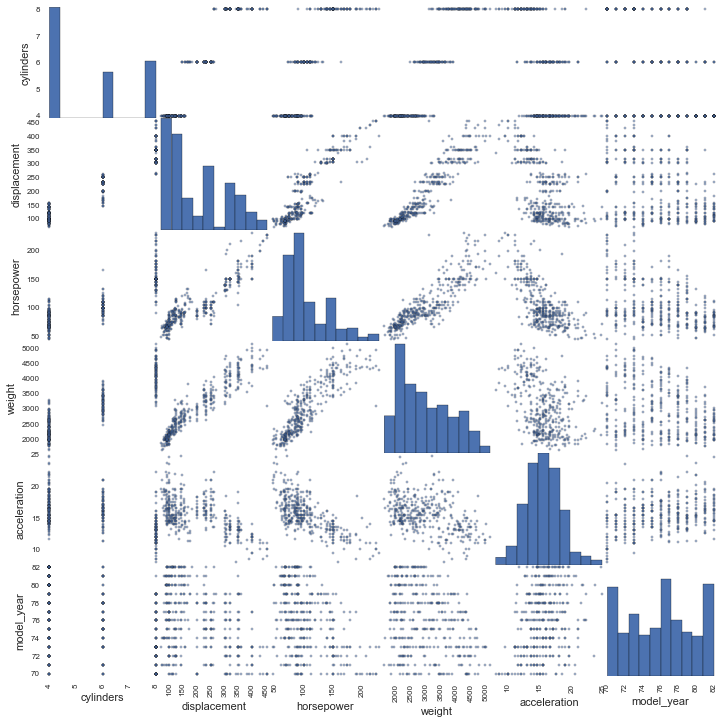

In [19]:
# Scatterplot matrix
from pandas.tools.plotting import scatter_matrix
ax = scatter_matrix(cars[num_vars],figsize=(12,12))


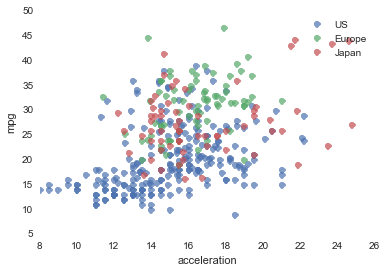

In [20]:
# Scatter plot by category
origins = cars['origin'].unique()
for origin in origins:
    plt.plot(cars.loc[cars.origin==origin,'acceleration'], 
             cars.loc[cars.origin==origin,'mpg'], 
             linestyle='',
             marker='o',
             alpha=.7,
             label=origin)
plt.xlabel('acceleration')
plt.ylabel('mpg')
plt.legend(numpoints=1)
    

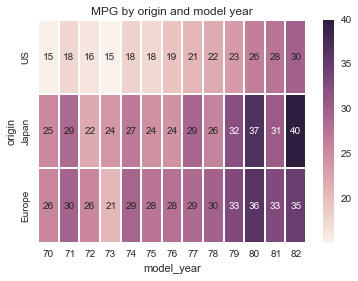

In [21]:
# Heat-map
import seaborn as sns

agg = cars.groupby(['origin','model_year'])['mpg'].mean()
ax = sns.heatmap(agg.unstack(level='model_year'), annot=True)
ax.set_title('MPG by origin and model year')

## Simple Linear Regression

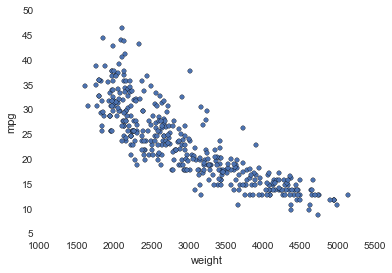

In [22]:
# Single variable regression
cars.plot('weight','mpg',kind='scatter')

## Ordinary least squares
It turns out that we can find the slope and intercept which *minimize* the mean squared error, using a procedure called ordinary least squares

Ordinary least squares is implemented in the statsmodels package. The advantage of this package is that we also have access to a number of *regression diagnostics.* 

In [23]:
import statsmodels.api as sm

# Choose the predictor and add a constant term
# (allow for an intercept)
X = pd.DataFrame({'weight' : cars['weight']})
X = sm.add_constant(X)
y = cars['mpg']

# Create a linear regression object
regressor = sm.OLS(y,X)
regressor = regressor.fit()
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     938.2
Date:                Mon, 02 Nov 2015   Prob (F-statistic):          5.03e-105
Time:                        07:55:52   Log-Likelihood:                -1100.1
No. Observations:                 385   AIC:                             2204.
Df Residuals:                     383   BIC:                             2212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         46.5027      0.783     59.394      0.000        44.963    48.042
weight        -0.0077      0.000    -30.630      0.000        -0.008    -0.007
==============================================================================
Omnibus:                       43.442   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.287
Skew:                           0.765   Prob(JB):                     2.98e-14
Kurtosis:                       4.243   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Diagnostics

**coef** - The values of the coefficients in the model

**$P>|t|$** - The p-value of the null hypothesis that a specific parameter is zero.

**R-Squared** - Proportion of variance explained by the model. Measured on a scale from 0 (bad) to 1 (good)

**Prob (F-statistic)** - p-value of the F-statistic. This is the probability of the null hypothesis that *all parameters in the model are zero*

(1000, 5500)

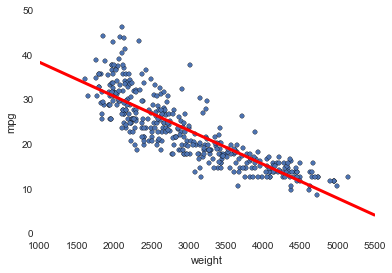

In [24]:
# Plot the line along with the data
slope = -.0076
intercept = 46.2165
ax = cars.plot('weight','mpg',kind='scatter')
xx = np.linspace(1000, 5500, 100)
ax.plot(xx, xx*slope + intercept, color='red', lw=3)
ax.set_xlim([1000,5500])

## Multiple Linear Regression
Use all of the numeric variables to fit a regression line.

In [25]:
# Choose the predictor and add a constant term
# (allow for an intercept)
X = cars[num_vars]
X = sm.add_constant(X)
y = cars['mpg']

# Create a linear regression object
regressor = sm.OLS(y,X)
regressor = regressor.fit()
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     288.5
Date:                Mon, 02 Nov 2015   Prob (F-statistic):          9.48e-138
Time:                        07:55:53   Log-Likelihood:                -1007.5
No. Observations:                 385   AIC:                             2029.
Df Residuals:                     378   BIC:                             2057.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const          -12.3204      4.682     -2.631      0.009       -21.527    -3.114
cylinders       -0.4863      0.327     -1.488      0.138        -1.129     0.156
displacement     0.0051      0.007      0.701      0.484        -0.009     0.019
horsepower       0.0044      0.014      0.328      0.743        -0.022     0.031
weight          -0.0066      0.001     -9.874      0.000        -0.008    -0.005
acceleration     0.0226      0.100      0.225      0.822        -0.175     0.220
model_year       0.7404      0.052     14.364      0.000         0.639     0.842
==============================================================================
Omnibus:                       49.043   Durbin-Watson:                   1.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.152
Skew:                           0.745   Prob(JB):                     7.21e-20
Kurtosis:                       4.810   Cond. No.                     8.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/zach/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


(0, 50)

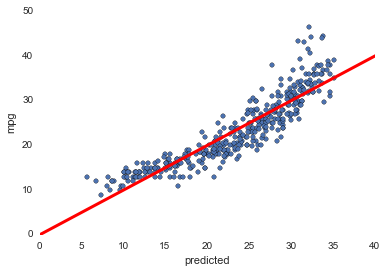

In [26]:
# Plot the predicted vs actual
cars['predicted'] = regressor.predict(X)
ax = cars.plot('predicted','mpg',kind='scatter')
xx = np.linspace(0, 50, 100)
ax.plot(xx, xx, color='red', lw=3)
ax.set_xlim([0,40])
ax.set_ylim([0,50])

#### Notes
- Only the bias term and the coefficients of weight and model year are statistically significant.
- There is a problem with this result though... multicollinearity!
- Does this look like it satisfies the regression assumptions?